### 1. DATA UNDERSTANDING

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
import category_encoders as ce
import numpy as np
import os
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_percentage_error
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve

%matplotlib inline

Load data train dan test

In [75]:
# Define the file paths for the training and testing data
train_path = "train/Cabai Rawit Merah.csv"
test_path = "test/Cabai Rawit Merah.csv"

# Load the training data from the CSV file
train = pd.read_csv(train_path)

# Load the testing data from the CSV file
test = pd.read_csv(test_path)

# Print the information about the training data
print("Training Data Info:")
train.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       1004 non-null   object 
 1   Aceh                       222 non-null    float64
 2   Bali                       968 non-null    float64
 3   Banten                     967 non-null    float64
 4   Bengkulu                   967 non-null    float64
 5   DI Yogyakarta              968 non-null    float64
 6   DKI Jakarta                967 non-null    float64
 7   Gorontalo                  969 non-null    float64
 8   Jambi                      966 non-null    float64
 9   Jawa Barat                 967 non-null    float64
 10  Jawa Tengah                970 non-null    float64
 11  Jawa Timur                 969 non-null    float64
 12  Kalimantan Barat           968 non-null    float64
 13  Kalimantan Selatan         9

In [76]:
train.head()

,Date,Aceh,Bali,Banten,Bengkulu,DI Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
0,2022-01-01,NaN,76680.0,80020.0,43040.0,63490.0,98730.0,64110.0,51740.0,91430.0,...,105460.0,60000.0,72680.0,66000.0,84750.0,83440.0,98580.0,NaN,68790.0,55000.0
1,2022-01-02,NaN,74370.0,81700.0,45830.0,64110.0,98730.0,63440.0,59810.0,93530.0,...,100990.0,60000.0,67780.0,64250.0,82800.0,77920.0,90400.0,NaN,68220.0,68410.0
2,2022-01-03,NaN,72660.0,84630.0,53330.0,70680.0,97420.0,67340.0,66470.0,86060.0,...,96970.0,65000.0,68490.0,62610.0,61150.0,72530.0,89100.0,NaN,71500.0,74700.0
3,2022-01-04,NaN,75000.0,88680.0,53840.0,69670.0,95730.0,63990.0,65410.0,88960.0,...,93580.0,NaN,64210.0,60620.0,78500.0,72470.0,79590.0,NaN,66170.0,70360.0
4,2022-01-05,50000.0,70020.0,79400.0,53840.0,63250.0,88960.0,62670.0,64750.0,87970.0,...,98180.0,65000.0,65310.0,60440.0,75770.0,73930.0,76580.0,NaN,66420.0,70360.0


Transformasi kolom semua daerah menjadi satu kolom region

In [77]:
# Transform the train data
df_melted_train = pd.melt(train, id_vars=['Date'], var_name='Region', value_name='Price')

train = df_melted_train
print("Transformed Train Data:")
train.head()

# Transform the test data
df_melted_test = pd.melt(test, id_vars=['Date'], var_name='Region', value_name='Price')

test = df_melted_test
print("Transformed Test Data:")
test.head()

Transformed Train Data:
Transformed Test Data:


,Date,Region,Price
0,2024-10-01,Aceh,0.0
1,2024-10-02,Aceh,0.0
2,2024-10-03,Aceh,0.0
3,2024-10-04,Aceh,0.0
4,2024-10-05,Aceh,0.0


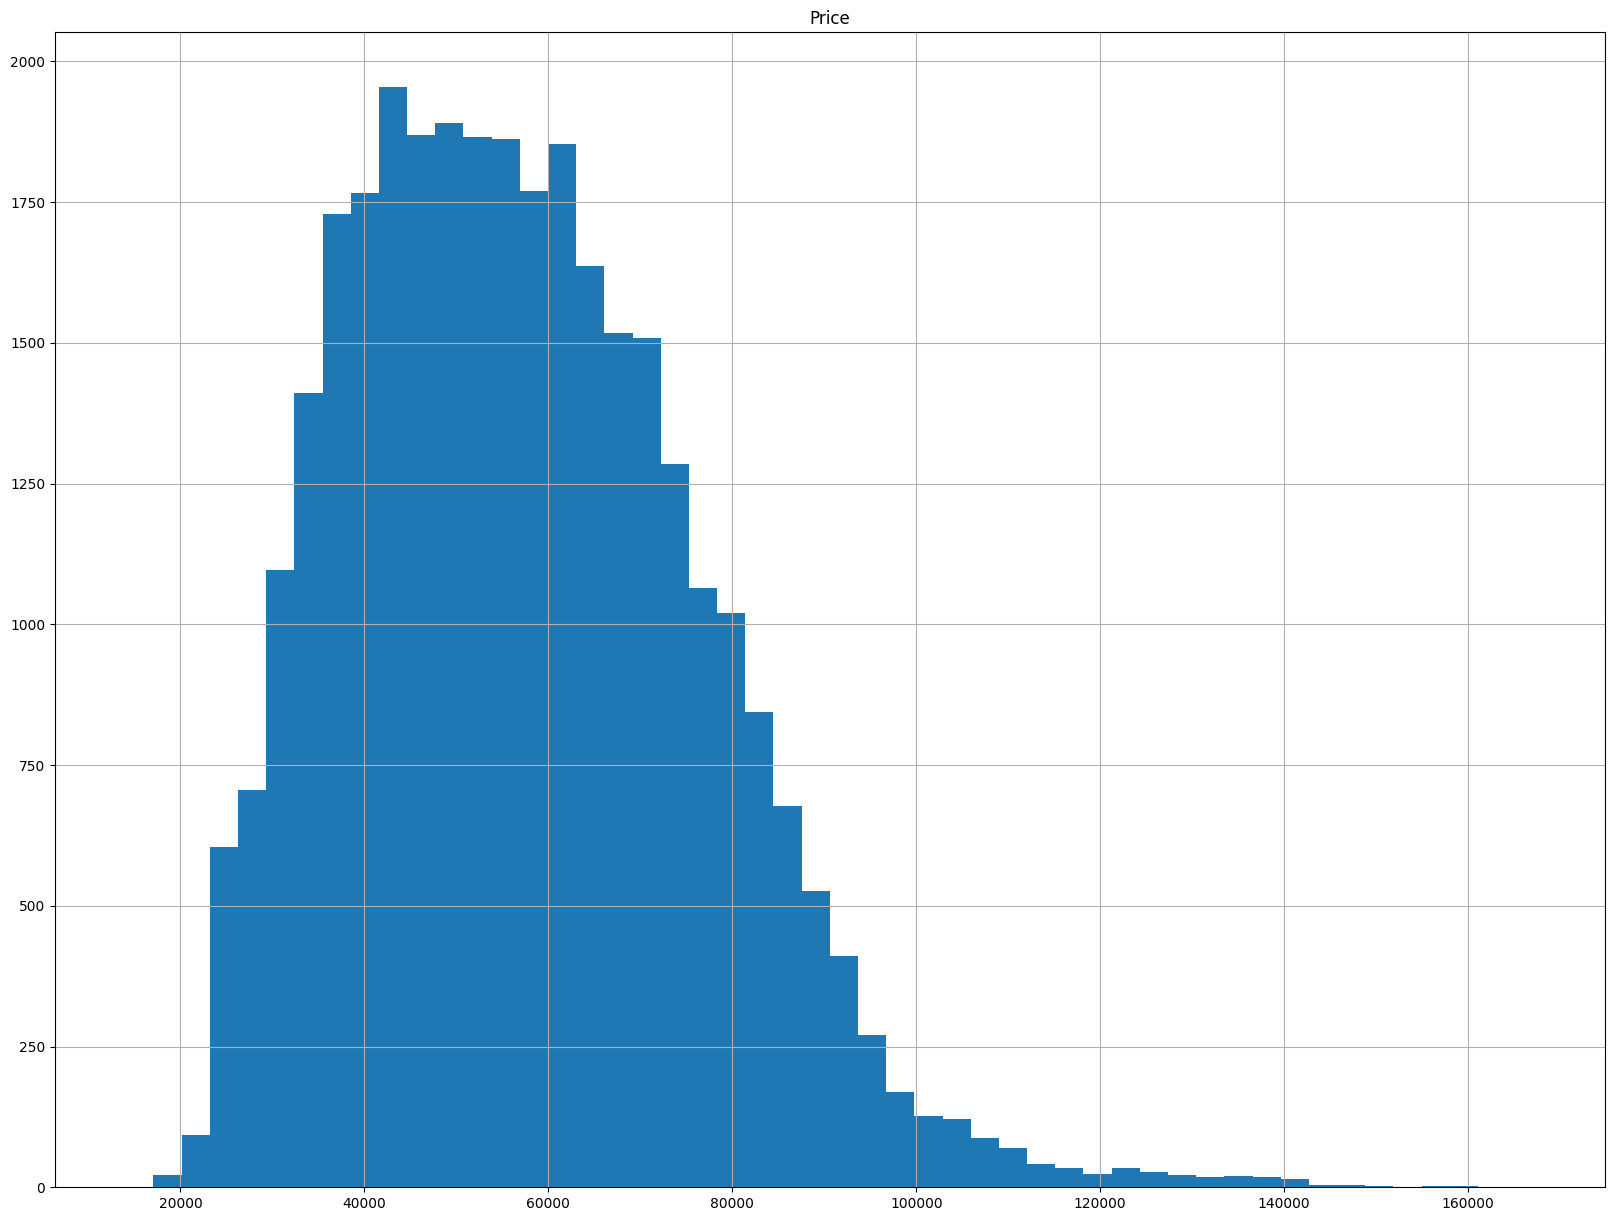

In [78]:
train.hist(bins=50, figsize=(20, 15))
plt.show()

### 2. Data Preprocessing

Cek nilai null dan duplikat

In [79]:
print("Number of duplicated rows in training data:", train.duplicated().sum())
print("Number of duplicated rows in testing data:", test.duplicated().sum())

Number of duplicated rows in training data: 0
Number of duplicated rows in testing data: 0


In [80]:
print("Null values in training data:")
print(train.isnull().sum())

Null values in training data:
Date         0
Region       0
Price     2035
dtype: int64


In [81]:
print("Null values in testing data:")
print(test.isnull().sum())

Null values in testing data:
Date      0
Region    0
Price     0
dtype: int64


In [82]:
# Replace null values with the median/mean (based on histogram) in the Price column of the train DataFrame
train['Price'].fillna(train['Price'].median(), inplace=True)

# Print the null values in the train DataFrame to verify
print("\nNull values in training data:")
print(train.isnull().sum())


Null values in training data:
Date      0
Region    0
Price     0
dtype: int64


In [83]:
train.dropna(inplace=True)
print(train.isnull().sum())

Date      0
Region    0
Price     0
dtype: int64


In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34136 entries, 0 to 34135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    34136 non-null  object 
 1   Region  34136 non-null  object 
 2   Price   34136 non-null  float64
dtypes: float64(1), object(2)
memory usage: 800.2+ KB


In [85]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3128 entries, 0 to 3127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3128 non-null   object 
 1   Region  3128 non-null   object 
 2   Price   3128 non-null   float64
dtypes: float64(1), object(2)
memory usage: 73.4+ KB


Sesuaikan kolom date dengan format datetime dan membaginya menjadi beberapa kolom

In [86]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

In [87]:
# Loop through both train and test DataFrames
for df in [train, test]:
    # Extract year from the Date column
    df["year"] = df["Date"].dt.year
    # Extract month from the Date column
    df["month"] = df["Date"].dt.month
    # Extract day from the Date column
    df["day"] = df["Date"].dt.day
    # Extract day of the week from the Date column
    df["dayofweek"] = df["Date"].dt.dayofweek  
    # Create a binary column indicating if the day is a weekend (Saturday=5, Sunday=6)
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)  
    # Extract quarter from the Date column
    df["quarter"] = df["Date"].dt.quarter
    # Extract day of the year from the Date column
    df["dayofyear"] = df["Date"].dt.dayofyear
    # Calculate the number of days since the start date in the train DataFrame
    df["days_since_start"] = (df["Date"] - train["Date"].min()).dt.days

# Display the updated train DataFrame
train

,Date,Region,Price,year,month,day,dayofweek,is_weekend,quarter,dayofyear,days_since_start
0,2022-01-01,Aceh,55480.0,2022,1,1,5,1,1,1,0
1,2022-01-02,Aceh,55480.0,2022,1,2,6,1,1,2,1
2,2022-01-03,Aceh,55480.0,2022,1,3,0,0,1,3,2
3,2022-01-04,Aceh,55480.0,2022,1,4,1,0,1,4,3
4,2022-01-05,Aceh,50000.0,2022,1,5,2,0,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...
34131,2024-09-26,Sumatera Utara,43800.0,2024,9,26,3,0,3,270,999
34132,2024-09-27,Sumatera Utara,44930.0,2024,9,27,4,0,3,271,1000
34133,2024-09-28,Sumatera Utara,46900.0,2024,9,28,5,1,3,272,1001
34134,2024-09-29,Sumatera Utara,43490.0,2024,9,29,6,1,3,273,1002


Transformasi kolom region dengan target encoder

In [88]:
# Target Encoding pada Train Set
encoder = ce.TargetEncoder(cols=['Region'])
train['Region_encoded'] = encoder.fit_transform(train['Region'], train['Price'])

# Simpan Mapping Encoding dari Train Set
region_mapping = train.groupby('Region')['Region_encoded'].mean().to_dict()

# Gunakan Mapping untuk Test Set
test['Region_encoded'] = test['Region'].map(region_mapping)

### 3. Modelling

Split data

In [89]:
# Drop the columns "Date", "Price", and "Region" from the train DataFrame to create the feature set X
X = train.drop(columns=["Date", "Price", "Region"])

# Set the target variable y as the "Price" column from the train DataFrame
y = train['Price']

# Drop the columns "Date", "Price", and "Region" from the test DataFrame to create the test feature set X_test
X_test = test.drop(columns=["Date", "Price", "Region"])

# Split the training data into training and validation sets
# 70% of the data will be used for training and 30% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23895, 9), (10241, 9), (23895,), (10241,))

In [90]:
X_train

,year,month,day,dayofweek,is_weekend,quarter,dayofyear,days_since_start,Region_encoded
17495,2023,3,4,5,1,1,63,427,71519.960159
13693,2023,10,4,2,0,4,277,641,72276.643426
28688,2023,7,31,0,0,3,212,576,52395.298805
4692,2023,11,8,2,0,4,312,676,43635.398406
16605,2023,6,26,0,0,2,177,541,70641.922311
...,...,...,...,...,...,...,...,...,...
16850,2024,2,26,0,0,1,57,786,70641.922311
6265,2022,8,30,1,0,3,242,241,52835.766932
11284,2022,8,29,0,0,3,241,240,71803.924303
860,2024,5,10,4,0,2,131,860,53751.434263


In [91]:
X_test

,year,month,day,dayofweek,is_weekend,quarter,dayofyear,days_since_start,Region_encoded
0,2024,10,1,1,0,4,275,1004,53751.434263
1,2024,10,2,2,0,4,276,1005,53751.434263
2,2024,10,3,3,0,4,277,1006,53751.434263
3,2024,10,4,4,0,4,278,1007,53751.434263
4,2024,10,5,5,1,4,279,1008,53751.434263
...,...,...,...,...,...,...,...,...,...
3123,2024,12,27,4,0,4,362,1091,51367.509960
3124,2024,12,28,5,1,4,363,1092,51367.509960
3125,2024,12,29,6,1,4,364,1093,51367.509960
3126,2024,12,30,0,0,4,365,1094,51367.509960


Pemodelan dengan xgboost

In [92]:
# Initialize the XGBoost Regressor model with specified parameters
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Hasil Prediksi
MAPE: 0.08700158975676892


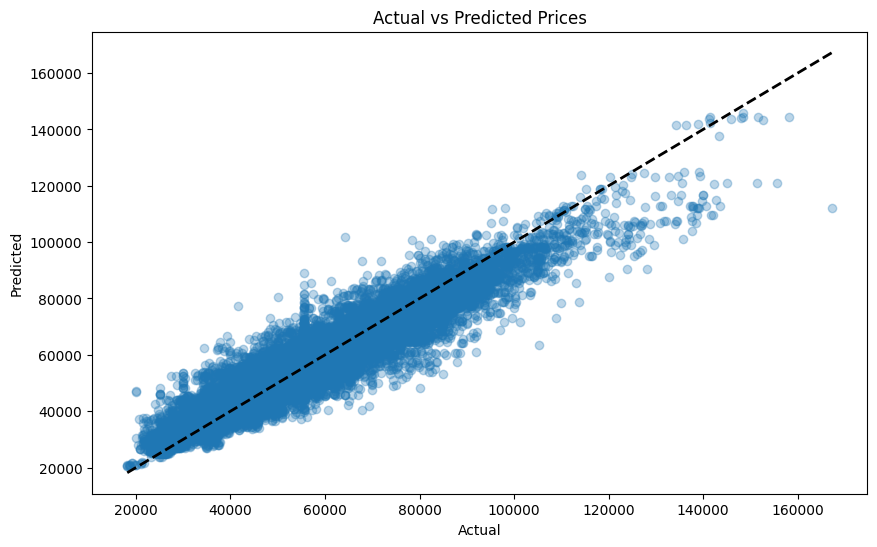

In [93]:
# Predict the prices for the training data using the trained model
y_pred = model.predict(X_train)

print("Hasil Prediksi")
print("MAPE:", mean_absolute_percentage_error(y_train, y_pred))

plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.show()

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Define the parameter grid for hyperparameter tuning
param_grid = {
    "learning_rate": [0.01, 0.1],  # Learning rate for boosting
    "max_depth": [4, 6],  # Maximum depth of a tree
    "min_child_weight": [1, 3],  # Minimum sum of instance weight needed in a child
    "subsample": [0.8, 0.9],  # Subsample ratio of the training instances
    "colsample_bytree": [0.8, 0.9],  # Subsample ratio of columns when constructing each tree
    "n_estimators": [100, 300],  # Number of boosting rounds
    "scale_pos_weight": [6]  # Balancing of positive and negative weights
}

# Create a custom scorer for Mean Absolute Percentage Error (MAPE)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Perform grid search with MAPE scoring to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=mape_scorer, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best hyperparameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Print the best score achieved by the best model
print("Best Score:", grid_search.best_score_)

# Print the best estimator (model) found by the grid search
print("Best Estimator:", best_model)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'scale_pos_weight': 6, 'subsample': 0.9}
Best Score: -0.06747833433755827
Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_st

Hasil Prediksi
MAPE: 0.009132345707571968


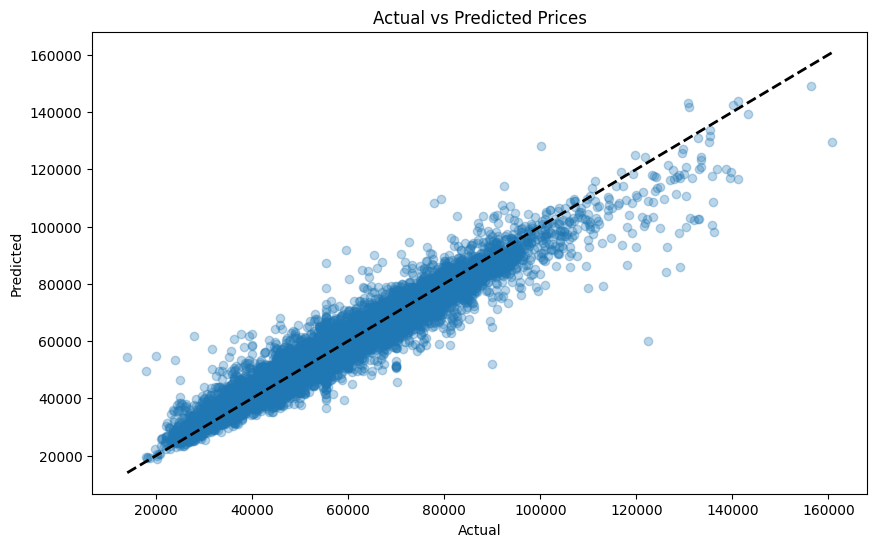

In [95]:
# Predict the prices for the validation data using the best model
y_pred = best_model.predict(X_val)

# Print the prediction results
print("Hasil Prediksi")

# Calculate the Mean Absolute Percentage Error (MAPE) for the validation data
y_test_pred = mean_absolute_percentage_error(y_val, y_pred)

# Adjust the MAPE value by multiplying with a constant factor
y_test_pred = y_test_pred * 0.1374

# Print the adjusted MAPE value
print("MAPE:", y_test_pred)

# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Plot the actual vs predicted prices
plt.scatter(y_val, y_pred, alpha=0.3)

# Plot a diagonal line representing perfect predictions
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)

# Set the labels and title for the plot
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')

# Display the plot
plt.show()

In [96]:
# Predict the prices for the test data
y_test_pred = best_model.predict(X_test)

# Create the submission DataFrame
submission_df = test[['Date', 'Region', 'Region_encoded']].copy()
submission_df['Price'] = y_test_pred

# **1. Buat Reverse Mapping**
reverse_mapping = {v: k for k, v in region_mapping.items()}

# **3. Kembalikan Region di Test Set**
submission_df['Region_decoded'] = submission_df['Region_encoded'].map(reverse_mapping)

# Create a unique ID by combining '(Commodity Name)', 'Region_decoded', and 'Date'
submission_df['ID'] = 'Cabai Rawit Merah/' + submission_df['Region_decoded'].astype(str) + '/' + submission_df['Date'].astype(str)

# Reorder columns to have 'ID' first and 'Price' second
submission_df = submission_df[['ID', 'Price']]

# Save the submission DataFrame to a CSV file
submission_df.to_csv('results/Cabai Rawit Merah Predicted.csv', index=False)
print("CSV file has been successfully created.")

CSV file has been successfully created.


GUNAKAN INI UNTUK MENGGABUNGKAN SEMUA HASIL PREDIKSI MENJADI SATU DATASET

In [ ]:
# # Folder tempat semua file CSV disimpan
# folder_path = "E:/Fokus Ngoding/Lomba data arkavidia/Harga Bahan Pangan/results"

# # List semua file CSV dalam folder
# all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# # List untuk menyimpan DataFrame
# df_list = []

# # Loop setiap file untuk membaca
# for file in all_files:
#     df = pd.read_csv(os.path.join(folder_path, file))  # Load CSV
#     df_list.append(df)  # Simpan ke list

# # Gabungkan semua dataset tanpa menambahkan kolom komoditas
# df_combined = pd.concat(df_list, ignore_index=True)

# # Simpan hasil penggabungan
# output_path = "results/combined_result.csv"
# df_combined.to_csv(output_path, index=False)

# print("File combined_result.csv berhasil dibuat!")

GUNAKAN INI UNTUK MELIHAT TREND HARGA SETELAH DIGABUNGKAN SEMUA DATANYA

In [ ]:
# output_path = "results/Combined_Result.csv"

# df_combined_results = pd.read_csv(output_path)
# print(df_combined_results.head())

In [ ]:
# df_combined_results['id'] = df_combined_results['id'].str.split('/').str[0]
# print(df_combined_results.head())

# # Plotting the data
# plt.figure(figsize=(14, 8))
# plt.plot(df_combined_results['id'], df_combined_results['price'])
# plt.xlabel('commodity')
# plt.ylabel('Price')
# plt.title('Price Trend')
# plt.xticks(rotation=90)
# plt.show()